# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [2]:
%pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# importujemy wszystkie potrzebne pakiety
from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [4]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [5]:
# inicjalizujemy ramiona bandytow - payout każdego ramienia bedzie reprezentowany przez rozkład normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkładzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i stały payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkładu normalnego lub wykładniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms+bad_arms}
arm_ids = list(arms.keys())

In [6]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.7368988255300275


In [7]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [8]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najlepsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, żeby metodą brute-force znaleźć wartość oczekiwaną
        return sum([payout_function() for i in range(n)]) / n

In [9]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [10]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 572.2800000000001
random: 280.12000000000006


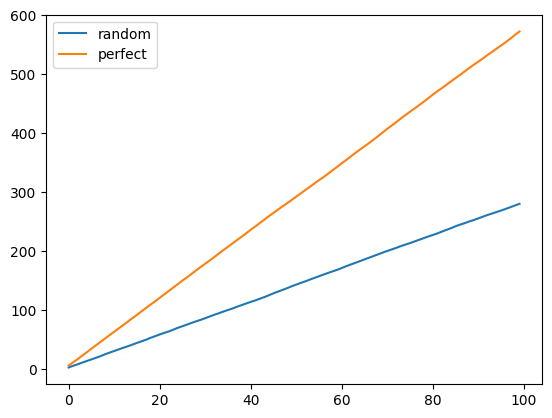

In [11]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.76
random: 2.76


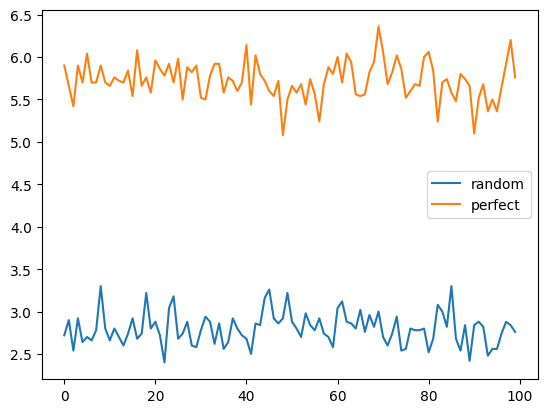

In [12]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [13]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        
    
    def recommend(self, size):
        sorted_arm_ids = sorted(self.arm_ids, key=lambda x: self.payouts_per_recommendation[x], reverse=True)
        randomized_arm_ids = sorted_arm_ids[:size]
        shuffle(randomized_arm_ids)
        
        recommendation = []
        for i in range(size):
            x = uniform(0, 1)
            recommended_arm_id = 0
            
            if x > self.epsilon:
                recommended_arm_id = randomized_arm_ids[i]
            else:
                recommended_arm_id = sorted_arm_ids[i]

            recommendation.append(recommended_arm_id)
            self.recommended_rates[recommended_arm_id] += 1
            
        return recommendation
        
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [14]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        # te zera w mianowniku mogą być problematyczne
        # - zastanów się, czy lepiej je obsługiwac w locie, czy zainicjalizować tę mapę wartościami niezerowymi
        self.recommended_rates = {arm_id: 1.0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0
    
    def recommend(self, size):
        self.n = size
        payouts_with_optimism = {arm_id: self.payouts_per_recommendation[arm_id] + self._optimism(arm_id) for arm_id in self.arm_ids}
        sorted_arm_ids = sorted(payouts_with_optimism, key=lambda x: payouts_with_optimism[x], reverse=True)
        recommendation = sorted_arm_ids[:size]
        for recommended_arm_id in recommendation:
            self.n += 1
            self.recommended_rates[recommended_arm_id] += 1
        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        return self.optimism_weight * sqrt(2 * log(self.n) / self.recommended_rates[arm])

In [15]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        return sorted(self.arm_ids, key=lambda arm_id: betavariate(self.a[arm_id], self.b[arm_id]), reverse=True)[:size]
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [29]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [26]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_5_50: 5.94
egreedy_0.05: 5.88
ts_1_50: 5.86
ts_10_1: 5.74
egreedy_0.1: 5.72
ts_5_20: 5.7
ts_5_10: 5.68
ts_1_5: 5.64
ts_5_1: 5.64
ts_10_20: 5.58
ts_1_1: 5.56
ts_1_10: 5.52
perfect: 5.5
egreedy_0.25: 5.5
ts_10_50: 5.5
ts_50_10: 5.48
ts_10_10: 5.38
egreedy_0.01: 5.34
ts_1_20: 5.3
ts_5_5: 5.3
ts_20_1: 5.28
ts_50_5: 5.22
ts_20_5: 5.16
ts_20_50: 5.1
ts_50_1: 5.08
ts_50_20: 5.08
ucb_1: 5.02
ts_50_50: 5.0
ts_20_10: 4.64
ucb_0.1: 4.6
ts_10_5: 4.5
ucb_0.01: 4.12
ts_20_20: 3.78
ucb_10: 3.1
random: 2.76


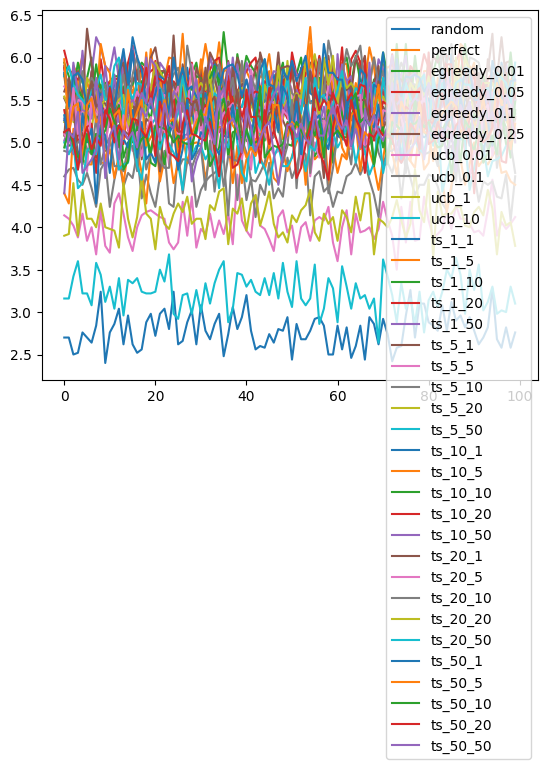

In [27]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

egreedy_0.05: 574.2000000000002
egreedy_0.01: 573.62
egreedy_0.25: 572.18
perfect: 572.1
ts_5_10: 569.78
ts_10_1: 567.1400000000003
egreedy_0.1: 565.5000000000002
ts_1_5: 562.3199999999997
ts_1_50: 557.9999999999999
ts_5_1: 557.8199999999998
ts_5_20: 554.4200000000002
ts_5_50: 553.86
ts_1_20: 553.2199999999999
ts_1_10: 552.0000000000001
ts_1_1: 549.7799999999999
ts_5_5: 545.4000000000001
ucb_1: 545.2399999999998
ts_10_20: 538.3
ts_10_50: 536.78
ts_20_1: 528.9599999999999
ts_50_5: 521.0000000000001
ts_50_1: 514.0000000000001
ts_20_5: 513.9000000000002
ts_10_10: 512.12
ts_50_50: 511.86000000000024
ts_50_10: 509.04
ts_50_20: 506.48
ts_20_10: 491.82
ts_20_50: 489.4
ts_10_5: 479.62000000000023
ucb_0.1: 454.1400000000001
ts_20_20: 412.4799999999999
ucb_0.01: 401.94000000000005
ucb_10: 323.52000000000004
random: 278.6199999999999


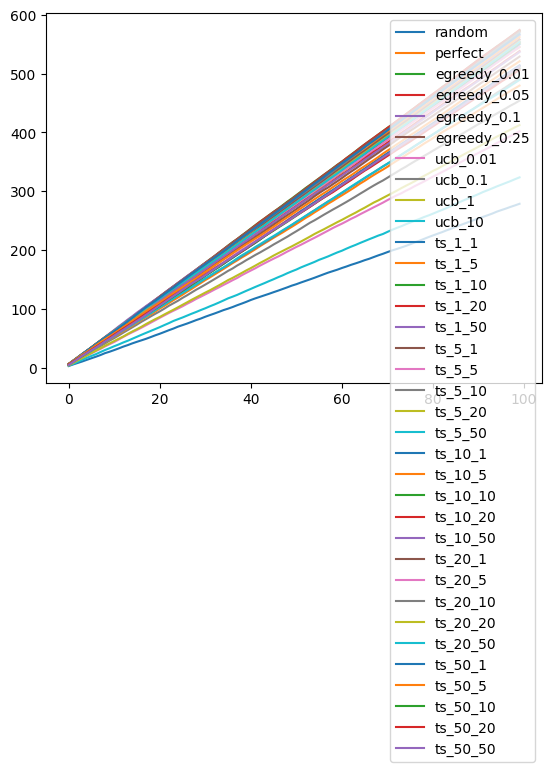

In [30]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [31]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return sum(1 for arm in recommendation if arm.arm_id.startswith('good_'))

all_relevant = relevant(arms.values())
all_relevant

10

In [32]:
# obliczmy precision@k i recall@k (zgodnie ze wzorami z wykladu)
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation) / all_relevant

In [33]:
# sprawdzmy, czy działa
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 0.6666666666666666
Recall@3 for bandit ts_50_50: 0.2


In [34]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
testing_bandits = [
    Perfect('perfect', arm_ids, arms),
    Random('random', arm_ids),
    EGreedy('egreedy_0.05', arm_ids, 0.05),
    UCB('ucb_0.01', arm_ids, 0.01),
    ThompsonSampling('ts_5_5', arm_ids, 5, 5)
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10

# dla kazdego bandyty - generujemy `samples` rekomendacji, liczymy precision i recall, wypisujemy srednie wartosci
# powtarzamy dla kazdego k
for k in k_vals:
    print(f'Precision@{k} and recall@{k} for {samples} samples:')
    for bandit in testing_bandits:
        precisions = []
        recalls = []
        for _ in range(samples):
            recommendation_ids = bandit.recommend(recommendation_size)
            recommendation = [arms[arm_id] for arm_id in recommendation_ids]
            precisions.append(precision_at_k(recommendation, k))
            recalls.append(recall_at_k(recommendation, k, all_relevant))
        print(f'Bandit {bandit.bandit_id}: precision: {sum(precisions)/samples}, recall: {sum(recalls)/samples}')
    print()

Precision@3 and recall@3 for 10 samples:
Bandit perfect: precision: 3.333333333333333, recall: 1.0
Bandit random: precision: 0.4, recall: 0.12
Bandit egreedy_0.05: precision: 3.333333333333333, recall: 1.0
Bandit ucb_0.01: precision: 0.33333333333333337, recall: 0.1
Bandit ts_5_5: precision: 0.19999999999999998, recall: 0.06

Precision@5 and recall@5 for 10 samples:
Bandit perfect: precision: 2.0, recall: 1.0
Bandit random: precision: 0.15999999999999998, recall: 0.07999999999999999
Bandit egreedy_0.05: precision: 2.0, recall: 1.0
Bandit ucb_0.01: precision: 0.2, recall: 0.1
Bandit ts_5_5: precision: 0.24000000000000005, recall: 0.12000000000000002

Precision@10 and recall@10 for 10 samples:
Bandit perfect: precision: 1.0, recall: 1.0
Bandit random: precision: 0.12, recall: 0.12
Bandit egreedy_0.05: precision: 1.0, recall: 1.0
Bandit ucb_0.01: precision: 0.1, recall: 0.1
Bandit ts_5_5: precision: 0.07999999999999999, recall: 0.07999999999999999

